In [1]:
# Imports
import scipy as sp
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

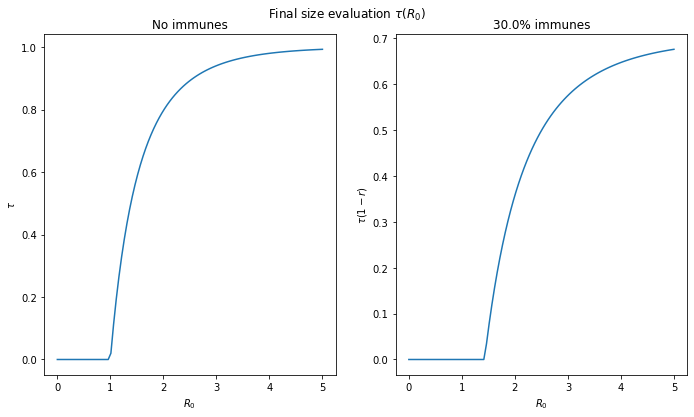

In [2]:
# Exercise 1
num_points = 100
r0s = np.linspace(0, 5, num_points)

def final_size_func(tau, *args):
    r0, frac_immune = args
    return 1 - tau - np.exp(-r0*(1-frac_immune)*tau)

taus = np.zeros(num_points)
taus_with_immunes = np.zeros(num_points)

for i, r0 in enumerate(r0s):
    taus[i] = opt.fsolve(final_size_func, 0.5, args=(r0, 0))

frac_immune = 0.3
    
for i, r0 in enumerate(r0s):
    taus_with_immunes[i] = opt.fsolve(final_size_func, 0.5, args=(r0, frac_immune)) * (1-frac_immune)
    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle(r'Final size evaluation $\tau(R_0)$')
axs[0].set_title('No immunes')
axs[0].set_ylabel(r'$\tau$')
axs[0].set_xlabel(r'$R_0$')
axs[0].plot(r0s, taus)
             
axs[1].set_title(f'{frac_immune*100}% immunes')
axs[1].set_ylabel(r'$\tau(1-r)$')
axs[1].set_xlabel(r'$R_0$')
axs[1].plot(r0s, taus_with_immunes)

plt.tight_layout(pad=2)
plt.show()

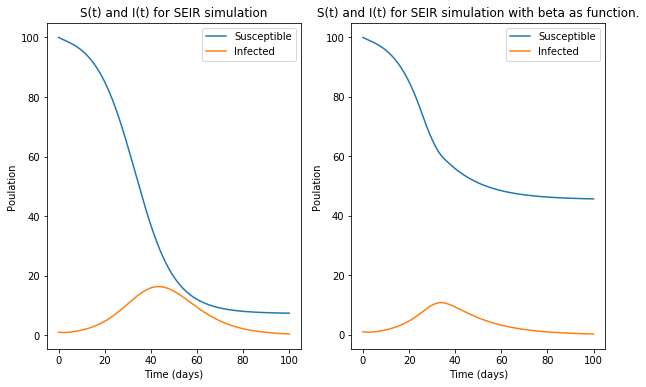

In [41]:
# Exercise 2

# a) WRITE UP SYSTEM
"""
dS/dt = -beta * S* I
dE/dt = beta * S* I - rho*E
dI/dt = rho*E - gam * I
dR/dt = gam * I
"""

# Exercise b -> d
def SEIR(beta, rho, gam, init, days=100, step_size=0.01, *args):
    steps = int(days/step_size) + 1
    t = np.linspace(0, days, steps)
    seir = np.zeros((steps, 4))
    seir[0] = init
    if not (isinstance(beta, float) or isinstance(beta, int)):
        # Is function
        variable_beta = True
    else:
        variable_beta = False
        _beta = beta
        
    for step in range(1, steps):
        if variable_beta:
            _beta = beta(t[step], *args)
        prev = seir[step-1]
        seir[step] = [  prev[0] + step_size * (-_beta * prev[0] * prev[2]),
                        prev[1] + step_size * ((_beta * prev[0] * prev[2]) - rho * prev[1]),
                        prev[2] + step_size * (rho * prev[1] - gam*prev[2]),
                        prev[3] + step_size * gam * prev[3]
                      ]
    return seir, t


def get_beta(t, beta0, beta1, t1, w):
    if t <= t1-w:
        beta = beta0
    elif t > t1+w:
        beta = beta1
    else:
        beta = beta0 + (t-t1+w)*(beta1-beta0)/(2*w)
        
    return beta

seir, t = SEIR(beta, rho, gam, init=[N-1, 0, 1, 0])

_args = [0.004, 0.0012, 30, 5]
var_seir, t = SEIR(get_beta, rho, gam, [N-1, 0, 1, 0], 100, 0.01, *_args)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].set_title('S(t) and I(t) for SEIR simulation')
ax[0].set_ylabel('Poulation')
ax[0].set_xlabel('Time (days)')

ax[0].plot(t, seir[:, 0])
ax[0].plot(t, seir[:, 2])

ax[0].legend(['Susceptible', 'Infected'])

ax[1].set_title('S(t) and I(t) for SEIR simulation with beta as function.')
ax[1].set_ylabel('Poulation')
ax[1].set_xlabel('Time (days)')

ax[1].plot(t, var_seir[:, 0])
ax[1].plot(t, var_seir[:, 2])

ax[1].legend(['Susceptible', 'Infected'])

plt.show()

In [69]:
# Exercise 3
with open('Data_2020-04-10Ny.txt', 'r') as f:
    dates, incidences = [], []
    lines = f.readlines()
    for line in lines[1:]:
        date, incidence = line.split()
        dates.append(date)
        incidences.append(int(incidence))
    date_idx = list(range(len(dates)))
    x_data = zip(date_idx, incidences)

In [87]:
N, rho = 2.37455e6, 1/5

"""
dS/dt = -beta*S*I
dE/dt = beta*S*I - rho*E
dI/dt = rho*E - gam * I
dR/dT = gam * I 
"""

def deriv(y, t, N, beta0, beta1, t1, w, rho, gamma):
    S, E, I, R = y
    beta = get_beta(t, beta0, beta1, t1, w)
    dSdt = -beta * S * I
    dEdt = beta * S * I - rho * E 
    dIdt = rho * E - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = N-1, 0, 1, 0
t = np.linspace()

ret = odeint(deriv, y0, t, args=(N, beta0, beta1, t1, w, rho, gamma))
S, E, I, R = ret.T

def _seir(beta0, beta1, t1, w, gam, rho, init):
    scipy.

def loss(params, observed_values):
    beta0, beta1, gam, t1, w = params
    beta = get_beta
    seir, t = SEIR(beta, 1/5, gam, [2.37455e6 - observed_values[0], 0, 1, 0], 53, 0.01, beta0, beta1, t1, w)
    I = seir[::100, 2]
    print(list(zip(I, observed_values)))
    return sum(np.power(I - observed_values, 2))


def lsq(params, observed_values):
    _opt = opt.minimize(loss, params, observed_values)
    return _opt.x

print(lsq([0.004, 0.0012, 1/7, 30, 5], incidences))
    


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


[(1.0, 1), (nan, 0), (nan, 0), (nan, 0), (nan, 1), (nan, 1), (nan, 3), (nan, 1), (nan, 0), (nan, 1), (nan, 2), (nan, 7), (nan, 26), (nan, 4), (nan, 4), (nan, 5), (nan, 6), (nan, 13), (nan, 10), (nan, 30), (nan, 28), (nan, 31), (nan, 35), (nan, 45), (nan, 51), (nan, 56), (nan, 34), (nan, 64), (nan, 68), (nan, 74), (nan, 98), (nan, 97), (nan, 148), (nan, 87), (nan, 84), (nan, 143), (nan, 142), (nan, 174), (nan, 150), (nan, 193), (nan, 138), (nan, 148), (nan, 201), (nan, 218), (nan, 247), (nan, 187), (nan, 181), (nan, 144), (nan, 140), (nan, 204), (nan, 206), (nan, 216), (nan, 185), (nan, 139)]
[(1.0, 1), (nan, 0), (nan, 0), (nan, 0), (nan, 1), (nan, 1), (nan, 3), (nan, 1), (nan, 0), (nan, 1), (nan, 2), (nan, 7), (nan, 26), (nan, 4), (nan, 4), (nan, 5), (nan, 6), (nan, 13), (nan, 10), (nan, 30), (nan, 28), (nan, 31), (nan, 35), (nan, 45), (nan, 51), (nan, 56), (nan, 34), (nan, 64), (nan, 68), (nan, 74), (nan, 98), (nan, 97), (nan, 148), (nan, 87), (nan, 84), (nan, 143), (nan, 142), (nan, 